In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib

In [2]:
# Load the dataset
df = pd.read_csv("new_wavelet_features.csv")

In [3]:
df.head()

,variance,skewness,kurtosis,entropy,class
0,18825.794527,-0.056914,0.018073,-0.006237,1
1,6841.258239,0.080827,0.148184,0.000645,1
2,14475.979899,0.004668,-0.027246,-0.000410,1
3,13457.590618,0.005749,0.011882,0.019889,1
4,9374.138184,-0.119408,-0.034655,0.003340,1


In [4]:
df.shape


(840, 5)

In [5]:
# Separate features and labels
X = df.drop(columns=["class"])
y = df["class"]

In [6]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [8]:
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Explicitly setting n_init
#     cluster_labels = kmeans.fit_predict(X_scaled)
#     silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

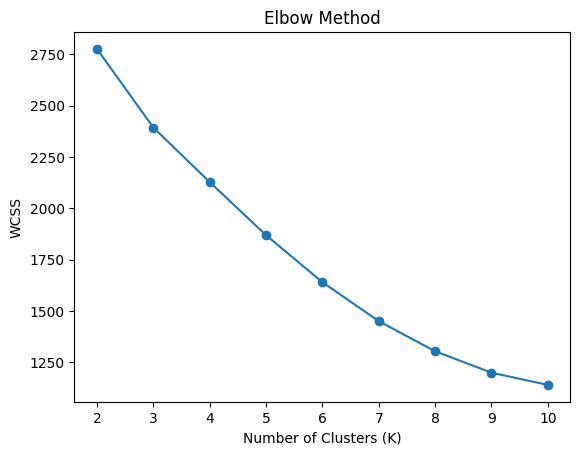

In [9]:
# # Plot silhouette scores
# plt.plot(range(2, 11), silhouette_scores)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs Number of Clusters')
# plt.show()

# Plot the Elbow Method graph
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()


In [10]:
# # Choose the optimal K based on the plot
# optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
# print("Optimal number of clusters (K):", optimal_k)
# Choose the optimal K based on the Elbow Method
optimal_k = np.argmin(np.diff(wcss)) + 2
print("Optimal number of clusters (K) using Elbow Method:", optimal_k)

Optimal number of clusters (K) using Elbow Method: 2


In [11]:
# Perform K-means clustering with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

In [12]:
# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print("Silhouette Score for optimal K:", silhouette_avg)

Silhouette Score for optimal K: 0.21856379460199257


In [13]:
# Assign labels to clusters based on majority voting
cluster_labels_df = pd.DataFrame({"cluster": cluster_labels, "class": y})
cluster_labels_df["predicted_class"] = cluster_labels_df.groupby("cluster")["class"].transform(lambda x: x.mode()[0])


In [14]:
# Evaluate accuracy
accuracy = (cluster_labels_df["class"] == cluster_labels_df["predicted_class"]).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7273809523809524


In [15]:
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [16]:
# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


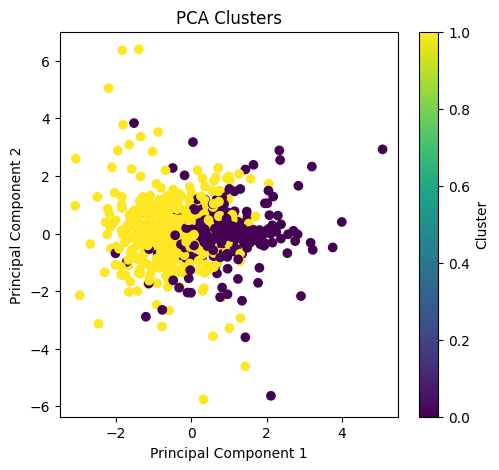

In [17]:
# Plot PCA clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

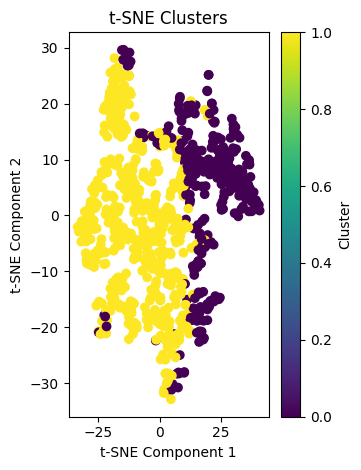

In [18]:
# Plot t-SNE clusters
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

In [19]:
# Save the trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')


['kmeans_model.pkl']

In [20]:
# Function to predict class label for new input
def predict_class(input_values):
    # Calculate mean and standard deviation from the original dataset (excluding the 'class' column)
    original_mean = df.drop(columns=['class']).mean()
    original_std = df.drop(columns=['class']).std()
    
    # Scale the input features using the mean and standard deviation
    input_scaled = (input_values - original_mean) / original_std
    
    # Predict cluster for scaled input
    cluster = kmeans.predict([input_scaled])[0]
    
    # Print the cluster for debugging
    print("Cluster:", cluster)
    
    # Retrieve majority class label assigned to the cluster
    majority_class = cluster_labels_df.loc[cluster_labels_df['cluster'] == cluster, 'predicted_class'].iloc[0]
    
    return majority_class
    
# Example input for new prediction
new_input = [12996.21848, 0.043632813, 0.01734375, 0.041497396]  # Adjust values as per your input features

# Predict class label for the input
predicted_class = predict_class(new_input)

# Output the predicted class label
print("Predicted Class Label:", "Real" if predicted_class == 0 else "Fake")

Cluster: 1
Predicted Class Label: Fake


In [21]:
# Evaluate accuracy
accuracy = (cluster_labels_df["class"] == cluster_labels_df["predicted_class"]).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7273809523809524
